In [289]:
# Import all necessary packages

import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt

In [290]:
# Mount the training and testing datasets and load them into pandas dataframe variables

df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

In [291]:
# Print the first couple entries in the training dataframe to get a general understanding of the training dataset

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [292]:
# Print some general information regarding the training set. As we can see, there are various properties that may have missing and
# non-numeric values that we need to address during the preprocessing stage.

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Number of unique keywords within training set: 222
Number of unique keywords within testing set: 222


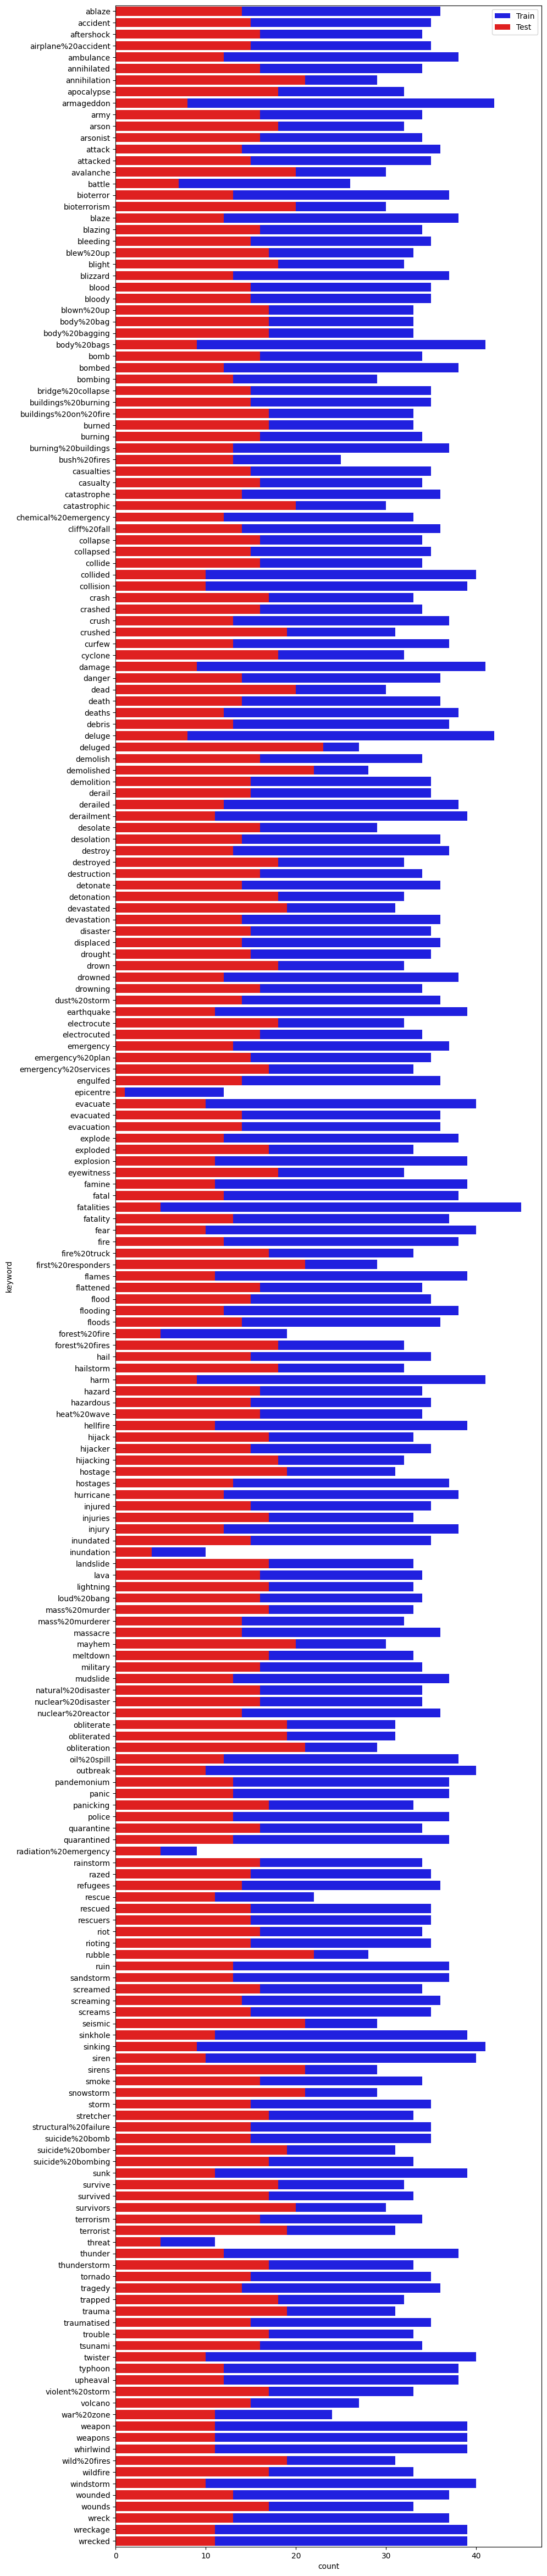

In [293]:
# Here we can see the distribution of the keywords within the training and the testing set and which keywords are more prevalent in each
# dataset.

plt.figure(figsize=(10,60))
print(f'Number of unique keywords within training set: {len(df_train.keyword.unique())}')
print(f'Number of unique keywords within testing set: {len(df_test.keyword.unique())}')
sns.countplot(y=df_train['keyword'], color=(0,0,1), label='Train')
sns.countplot(y=df_test['keyword'], color=(1,0,0), label='Test')
plt.legend()

<Axes: xlabel='count', ylabel='keyword'>

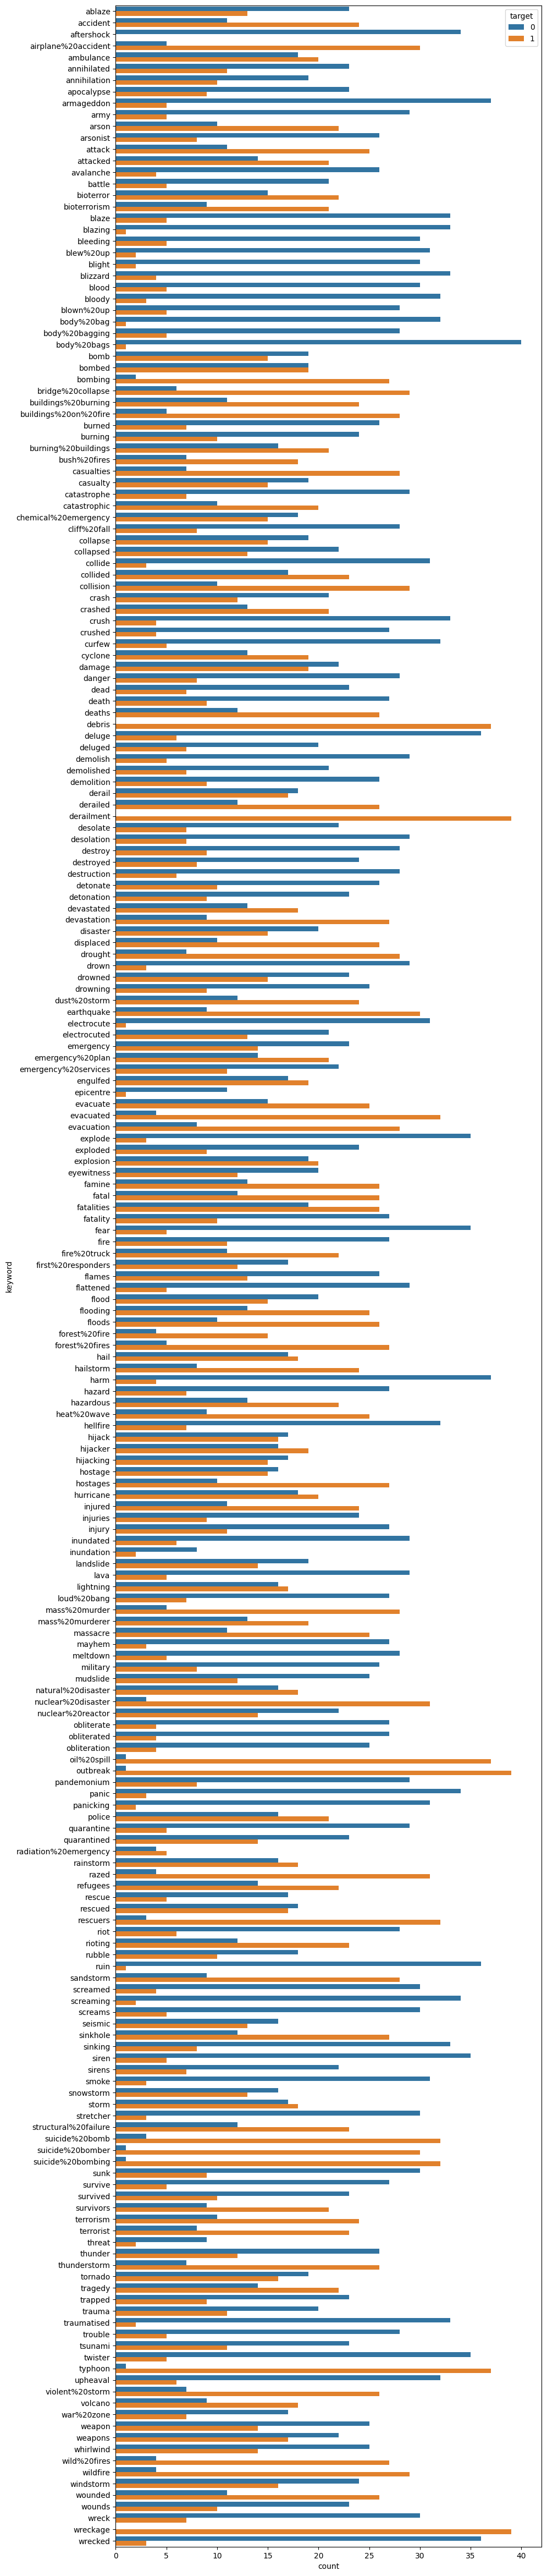

In [294]:
# Here we can generate a bar chart showing the associativity of the keywords to each class [real-disasater, non-disaster] to understand
# if there is any reason to consider the usage of the keywords associated with the tweet in the training process.

plt.figure(figsize=(10,60))
sns.countplot(data = df_train, y='keyword', hue='target')

In [295]:
nltk.download('all')
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    text = text.lower()

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs
    #text = re.sub(r"http", "",text)

    html=re.compile(r'<.*?>')

    text = html.sub(r'',text) #Removing html tags

    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations

    text = [word.lower() for word in text.split() if word.lower() not in sw]

    text = [lemmatizer.lemmatize(word) for word in text]

    text = " ".join(text) #removing stopwords and lemmatizing

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis

    return text

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

In [296]:
# Now we need to preprocess the dataset. We can apply the text cleaning solution as shown above to the training set and fill null values
# in the column entries with NaN.

def preprocess(df):
  df['text'] = df['text'].apply(lambda x: clean_text(x))
  df = df.fillna('NaN', axis=1)
  # df['text'] = 'KEYWORD= ' + df.keyword + '; LOCATION= ' + df.location + '; TEXT= ' + df.text
  # df.drop(["id", "keyword", "location"], inplace=True, axis=1)
  return df

In [297]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)

In [298]:
df_train.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [299]:
df_train.shape

(7613, 5)

<Axes: >

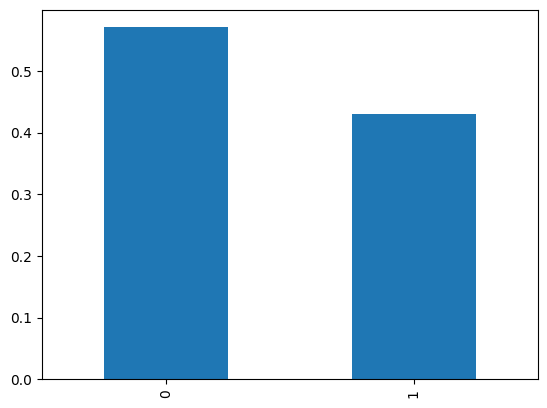

In [300]:
# To get an idea of how balanced this dataset is, we can plot the normalized label counts for each class [non-disaster, real-disaster] as
# a bar chart.

df_train['target'].value_counts(normalize=True).plot.bar()

In [301]:
# Since there is a considerable data imbalance, we need to address this by performing some further preprocessing. One method to handle this
# phenomenon is known as oversampling. This technique involves repeatedly sampling (with replacement) the data from the imbalanced minority
# class (real-disaster) at random and adding them to the training set to correct the imbalance.

from imblearn.over_sampling import RandomOverSampler

# Randomly oversample the minority class (real-disaster class)
ros = RandomOverSampler(random_state=42)
print(df_train['target'].dtype)
df_train, _ = ros.fit_resample(df_train, df_train['target'].astype('int'))

object


<Axes: >

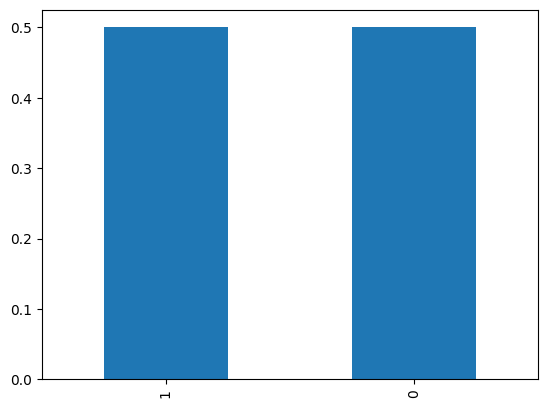

In [302]:
# After performing the oversampling technique, the distribution of all tweets should be eveb per the two classes [real-disaster, non-disaster].
# There should no longer be a class imbalance.

df_train['target'].value_counts(normalize=True).plot.bar()

In [303]:
# Split the training set into a training and validation set to test the model's ability to generalize

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.3

from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]
y=y.astype('int')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [304]:
X_train

3455    man squeeze another man head bare hand literal...
5250    refugio oil spill may costlier bigger projecte...
3682    cat fatality utica ny pleasant amp holland ave...
1498    climate change could catastrophic benefit real...
4329    criminal hijack lorry bus arrested enugu photo...
                              ...                        
5734    video picking body water rescuer searching hun...
5191    dude obliterated meek mill dont judge book cov...
5390    panic attack bc enough money drug alcohol want...
860     omron hem c automatic blood pressure monitor s...
7270    moved england five year ago today whirlwind ti...
Name: text, Length: 6078, dtype: object

In [305]:
# Train Bag of Words model on the X_train corpus training data

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

X_train_cv = cv.fit_transform(X_train)

X_train_cv.shape

(6078, 16781)

In [306]:
# Visualize the feature matrix generated by the CountVectorizer. Each key in the printed dictionary is the word from the text document fed
# to the CountVectorizer and the value for that key is the index of that word in the feature matrix

print(f"Vocabulary mapping for disaster text corpus : \n {cv.vocabulary_}")

Vocabulary mapping for disaster text corpus : 
 {'man': 8656, 'squeeze': 13446, 'another': 507, 'head': 6033, 'bare': 1037, 'hand': 5915, 'literally': 8269, 'exploded': 4516, 'refugio': 11864, 'oil': 10142, 'spill': 13383, 'may': 8775, 'costlier': 2763, 'bigger': 1298, 'projected': 11207, 'http': 6410, 'tco': 14003, 'lzob': 8573, 'qoh': 11499, 'cat': 2051, 'fatality': 4658, 'utica': 15111, 'ny': 9979, 'pleasant': 10905, 'amp': 436, 'holland': 6274, 'ave': 870, 'black': 1382, 'white': 15750, 'paw': 10600, 'average': 874, 'size': 13050, 'grass': 5685, 'next': 9680, 'north': 9841, 'side': 12965, 'road': 12219, 'climate': 2426, 'change': 2189, 'could': 2769, 'catastrophic': 2056, 'benefit': 1205, 'really': 11788, 'weathernetwork': 15649, 'ibx': 6549, 'cragtt': 2824, 'criminal': 2869, 'hijack': 6171, 'lorry': 8418, 'bus': 1812, 'arrested': 681, 'enugu': 4277, 'photo': 10775, 'donjazzy': 3675, 'policeng': 10978, 'humanrights': 6441, 'xyfl': 16297, 'wy': 16093, 'yr': 16493, 'old': 10187, 'pkk

In [307]:
y_train

3455    0
5250    1
3682    0
1498    0
4329    1
       ..
5734    1
5191    0
5390    0
860     0
7270    1
Name: target, Length: 6078, dtype: int64

In [308]:
# Training Logistic Regression model

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', class_weight='balanced', dual=True, C=0.8)
lr.fit(X_train_cv, y_train)


# transform X_val using CV
X_val_cv = cv.transform(X_val)


# generate predictions
val_predictions = lr.predict(X_val_cv)
val_predictions

array([0, 0, 0, ..., 1, 1, 0])

In [309]:
# Print the classification report that returns the precision, recall, f1-score, and support classification metrics from the training

from sklearn.metrics import classification_report
print(classification_report(y_val, val_predictions))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1311
           1       0.85      0.82      0.83      1295

    accuracy                           0.84      2606
   macro avg       0.84      0.84      0.84      2606
weighted avg       0.84      0.84      0.84      2606



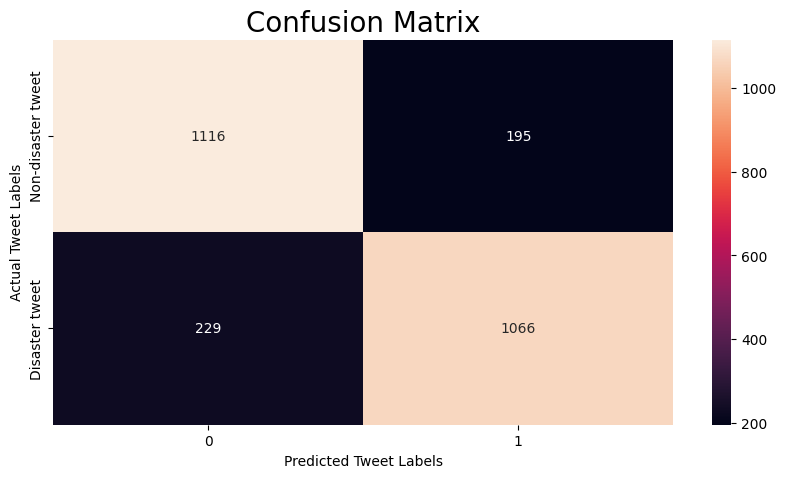

In [310]:
# Generate the confusion matrix that shows the true positive, true neative, false positive, and false negative labels

matrix = confusion_matrix(y_val, val_predictions)
labels= ["Non-disaster tweet", "Disaster tweet"]
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(matrix, annot=True, fmt="g", ax=ax)
plt.xlabel("Predicted Tweet Labels")
plt.ylabel("Actual Tweet Labels")
plt.title("Confusion Matrix", size=20)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

In [311]:
# Print the accuracy for the training set

print("Training set accuracy: ", lr.score(X_train_cv, y_train))

Training set accuracy:  0.9717012175057584


In [312]:
# Print the accuracy for the validation set

print("Validation set accuracy: ", lr.score(X_val_cv, y_val))

Validation set accuracy:  0.837298541826554


In [313]:
# Print the F1-score metric for the validation set

from sklearn.metrics import f1_score
f1 = f1_score(y_val, val_predictions)
print("F1 Score: ", f1)

F1 Score:  0.8341158059467919


In [314]:
# Preparing submission

# transform X_test using CV
X_test_cv = cv.transform(X_test)


# generate predictions
test_predictions = lr.predict(X_test_cv)
test_predictions

array([1, 1, 1, ..., 1, 1, 0])

In [315]:
predicted_df = df_test.copy()
predicted_df['target'] = test_predictions

In [316]:
# Generate some predictions on the testing data

predicted_df

,id,keyword,location,text,target
0,0,NaN,NaN,happened terrible car crash,1
1,2,NaN,NaN,"heard earthquake different cities, stay safe e...",1
2,3,NaN,NaN,"forest fire spot pond, goose fleeing across st...",1
3,9,NaN,NaN,apocalypse lighting spokane wildfire,1
4,11,NaN,NaN,typhoon soudelor kill china taiwan,1
...,...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles safety fastener ...,1
3259,10865,NaN,NaN,storm ri worse last hurricane city amp others ...,1
3260,10868,NaN,NaN,green line derailment chicago http tco utbxlcbiuy,1
3261,10874,NaN,NaN,meg issue hazardous weather outlook hwo http t...,1


In [317]:
# Save testing set predictions dataframe into a csv file.

submission_df = pd.read_csv(f'/content/sample_submission.csv')
submission = pd.DataFrame({"id": submission_df['id'],
            "target":test_predictions})
submission.to_csv('/content/submission.csv', index=False)